## IFT6390 Devoir 3
### Thomas George, Marc-Antoine Sayn-Urpar
# Partie Pratique: Implémentation du réseau de neurones

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from __future__ import unicode_literals

import time

### Fonction softmax numériquement stable

In [2]:
def softmax(x):
    x_max = np.max(x, axis=0)
    r = np.exp(x - x_max)
    return r / np.sum(r, axis=0)

### Classe multilayer perceptron

In [3]:
class MLP(object):
    
    def __init__(self, d, dh, m):
        self.m = m
        self.dh = dh
        self.d = d
        
        # ce seed sert à pouvoir comparer les différents modèles
        # en ne tenant pas compte des performances liées à une meilleure
        # initilisation "par chance"
        np.random.seed(123)
        
        self.w1 = self.init_w(d, dh)
        self.w2 = self.init_w(dh, m)
        self.b1 = self.init_b(dh)
        self.b2 = self.init_b(m)
        
    def init_w(self, d1, d2):
        return np.random.uniform(-1/d1**0.5, 1/d1**0.5, (d2, d1))
    
    def init_b(self, d):
        return np.zeros((d, 1))
    
    def train(self, x, y, n_iter=100, batch_size=100, learning_rate=0.1, weight_decay=0.001, callback=None):
        """
        Lance l'apprentissage
        
        x: données d'apprentissage, un exemple par ligne
        y: valeurs des classes pour les données d'apprentissage, chaque ligne représente un exemple
        n_iter: nombre maximum d'époques
        batch_size: taille des batchs
        learning_rate: paramètre pour la descente de gradient
        weight_decay: régularisation L2
        callback: fonction appelée à chaque époque, si elle renvoi False alors on stoppe l'apprentissage
        """
        
        for current_iter in range(n_iter):
            loss = 0
            for i in range(int(x.shape[0] / batch_size)):
                # prendre en compte le dernier batch qui peut être de longueur < batch_size
                n = min(batch_size, x.shape[0]-i*batch_size)

                (grad_b2, grad_w2, grad_b1, grad_w1, batch_loss) = self.gradient_batch(x[i*batch_size:i*batch_size+n], y[i*batch_size:i*batch_size+n])

                # mise à jour des paramètres
                self.w1 -= learning_rate * grad_w1 + weight_decay * self.w1 / n
                self.b1 -= learning_rate * grad_b1 + weight_decay * self.b1 / n
                self.w2 -= learning_rate * grad_w2 + weight_decay * self.w2 / n
                self.b2 -= learning_rate * grad_b2 + weight_decay * self.b2 / n
            
                loss += batch_loss
                
            # appel d'un callback à chaque époque qui détermine si on
            # doit arrêter l'entrainement
            if callback != None:
                if callback(self, loss/int(x.shape[0] / batch_size)) == False:
                    break
    
    def gradient_batch(self, x, y):
        """
        Calcule les gradients sur un batch
        
        x: valeurs de x, chaque ligne représente un exemple
        y: valeurs des classes à prédire, chaque ligne représente un exemple
        """
        n = x.shape[0]
        sum_grad_w1 = np.zeros((self.dh, self.d))
        sum_grad_b1 = np.zeros((self.dh, 1))
        sum_grad_w2 = np.zeros((self.m, self.dh))
        sum_grad_b2 = np.zeros((self.m, 1))
        
        for i in range(n):
            (ha, hs, oa, os) = self.fprop(x[i].T.reshape(-1, 1))
            (grad_b2, grad_w2, grad_b1, grad_w1) = self.bprop(x[i].T.reshape(-1, 1), y[i], ha, hs, oa, os)              
            sum_grad_w1 += grad_w1
            sum_grad_b1 += grad_b1
            sum_grad_w2 += grad_w2
            sum_grad_b2 += grad_b2
            
        loss = -np.sum(np.log(os[y]))/n
            
        return (sum_grad_b2/n, sum_grad_w2/n, sum_grad_b1/n, sum_grad_w1/n, loss)
        
    def gradient_num(self, x, y, os, param, epsilon=10**-9):
        """
        Calcule un gradient par différence finie
        
        x: valeur de x où vérifier le gradient
        y: valeur de y où vérifier le gradient
        value: valeur calculée par back prop
        param: référence vers le paramètre dont on vérifie le gradient
        epsilon: valeur d'epsilon pour les différences finies
        """
        gradient_diff = np.zeros(param.shape)
        for i in range(param.shape[0]):
            for j in range(param.shape[1]):
                param[i, j] += epsilon
                (new_ha, new_hs, new_oa, new_os) = mlp.fprop(x)
                gradient_diff[i, j]  = np.log (os[y][0]/new_os[y][0]) / epsilon
                param[i, j] -= epsilon
                
        return gradient_diff
            
    def predict(self, x):
        ha, hs, oa, os = self.fprop(x.T)
        return np.argmax(os, axis=0)
    
    def fprop(self, x):
        """
        Forward propagation
        
        x: données d'entrainement, un exemple par colonne
        """
        ha = np.dot(self.w1, x) + self.b1
        hs = (ha > 0) * ha
        oa = np.dot(self.w2, hs) + self.b2
        os = softmax(oa)
        
        return (ha, hs, oa, os)
        
    def bprop(self, x, y, ha, hs, oa, os):
        """
        Back propagation
        
        x: vecteur colonne donnée d'entrainement
        y: classe de l'exemple
        ha, hs, oa, os: valeurs retournées par la fonction fprop
        """
        grad_oa = os.copy()
        grad_oa[y, 0] -= 1
        grad_b2 = grad_oa
        grad_w2 = np.dot(grad_oa, hs.T)
        grad_hs = np.dot(self.w2.T, grad_oa)
        grad_ha = (ha > 0) * grad_hs
        grad_b1 = grad_ha
        grad_w1 = np.dot(grad_ha, x.T)
        
        return (grad_b2, grad_w2, grad_b1, grad_w1)

### 1. Vérification du gradient par différence finie

Le calcul des gradients par différences finies est réalisé par la fonction gradient_num ci-dessus.

### 2. Affichage des résultats

Voici une comparaison des gradients produits par différence finie et directement par back prop. Les gradients sont calculés en un point x généré aléatoirement.

Les valeurs sont très proches, on peut donc valider l'implémentation par back prop.

In [4]:
d = 2
dh = 2
m = 2
mlp = MLP(d, dh, m)
epsilon = 10**-6
y = 1

# Point au hasard où vérifier le gradient
x = np.random.uniform(epsilon, 1, (d, 1))

(ha, hs, oa, os) = mlp.fprop(x)
(grad_b2, grad_w2, grad_b1, grad_w1) = mlp.bprop(x, y, ha, hs, oa, os)

# Vérification du gradient w1
grad_w1_num = mlp.gradient_num(x, y, os, mlp.w1)
print '- affichage de w1'
print grad_w1
print grad_w1_num

# Vérification du gradient pour b1
grad_b1_num = mlp.gradient_num(x, y, os, mlp.b1)
print '- affichage de b1'
print grad_b1
print grad_b1_num

# Vérification du gradient w2
grad_w2_num = mlp.gradient_num(x, y, os, mlp.w2)
print '- affichage de w2'
print grad_w2
print grad_w2_num

# Vérification du gradient pour b2
grad_b2_num = mlp.gradient_num(x, y, os, mlp.b2)
print '- affichage de b2'
print grad_b2
print grad_b2_num

- affichage de w1
[[-0.08861201 -0.07224794]
 [ 0.          0.        ]]
[[-0.08861212 -0.0722481 ]
 [ 0.          0.        ]]
- affichage de b1
[[-0.18425045]
 [-0.        ]]
[[-0.18425073]
 [ 0.        ]]
- affichage de w2
[[ 0.0074955  0.       ]
 [-0.0074955  0.       ]]
[[ 0.00749534  0.        ]
 [-0.00749556  0.        ]]
- affichage de b2
[[ 0.49861125]
 [-0.49861125]]
[[ 0.49861115]
 [-0.49861137]]


### 3. Vérification du gradient batch par différence finie                                                   

L'implémentation est réalisée dans la fonction gradient_batch ci-dessus.

### 4. Affichage des résultats

Voici une comparaison des gradients produits par différence finie et directement par back prop pour un batch. Les gradients sont calculés pour un ensemble de points générés aléatoirement.

Les valeurs sont très proches, on peut donc valider l'implémentation du gradient sur des batchs.

In [5]:
d = 5
dh = 4
m = 2
mlp = MLP(d, dh, m)
epsilon = 10**-9
n = 10

# n point au hasard où vérifier le gradient
x = np.random.uniform(epsilon, 1, (n, d))
y = np.random.binomial(1, 0.5, n)

all_os_values = []
for i in range(n):
    (ha, hs, oa, os) = mlp.fprop(x[i].T.reshape(-1, 1))
    all_os_values.append(os)
    
(grad_b2, grad_w2, grad_b1, grad_w1, loss) = mlp.gradient_batch(x, y)

# Vérification du gradient w1
grad_w1_num = np.zeros(mlp.w1.shape)
for i in range(n):
    grad_w1_num += mlp.gradient_num(x[i].T.reshape(-1, 1), y[i], all_os_values[i], mlp.w1)
grad_w1_num /= n
print '- affichage de w1'
print grad_w1
print grad_w1_num

# Vérification du gradient b1
grad_b1_num = np.zeros(mlp.b1.shape)
for i in range(n):
    grad_b1_num += mlp.gradient_num(x[i].T.reshape(-1, 1), y[i], all_os_values[i], mlp.b1)
grad_b1_num /= n
print '- affichage de b1'
print grad_b1
print grad_b1_num

# Vérification du gradient w2
grad_w2_num = np.zeros(mlp.w2.shape)
for i in range(n):
    grad_w2_num += mlp.gradient_num(x[i].T.reshape(-1, 1), y[i], all_os_values[i], mlp.w2)
grad_w2_num /= n
print '- affichage de w2'
print grad_w2
print grad_w2_num

# Vérification du gradient w1
grad_b2_num = np.zeros(mlp.b2.shape)
for i in range(n):
    grad_b2_num += mlp.gradient_num(x[i].T.reshape(-1, 1), y[i], all_os_values[i], mlp.b2)
grad_b2_num /= n
print '- affichage de b2'
print grad_b2
print grad_b2_num

- affichage de w1
[[-0.00624873 -0.00857993 -0.00193006 -0.00454523 -0.0074082 ]
 [ 0.01395919  0.03886487 -0.00392718  0.02431311  0.03643344]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[-0.00624871 -0.00857991 -0.00193001 -0.00454521 -0.00740819]
 [ 0.01395921  0.0388649  -0.00392711  0.02431321  0.03643351]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
- affichage de b1
[[-0.00610406]
 [ 0.01170975]
 [ 0.        ]
 [ 0.        ]]
[[-0.00610402]
 [ 0.0117098 ]
 [ 0.        ]
 [ 0.        ]]
- affichage de w2
[[ 0.00736216  0.02122182  0.          0.        ]
 [-0.00736216 -0.02122182  0.          0.        ]]
[[ 0.00736221  0.02122181  0.          0.        ]
 [-0.00736211 -0.02122176  0.          0.        ]]
- affichage de b2
[[ 0.02224189]
 [-0.02224189]]
[[ 0.02224193]
 [-0.02224186]]


### 5. Exemple données 2 moons

Dans la suite, nous chargeons les données 2 moons et nous entrainons un MLP pour différents paramètres.

In [6]:
data = np.loadtxt(open('2moons.txt','r'))
data_x = data[:, :-1]
data_y = data[:, -1].astype(np.int32)

In [7]:
# Fonction qui sert à afficher les régions de décision

x_min, x_max = -2, 2
y_min, y_max = -2.3, 2.3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
    
def plot_regions(predictor, axe):
    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axe.imshow(Z, extent=(x_min, x_max, y_min, y_max), alpha=0.4, origin='lower', interpolation='none')
    axe.scatter(data_x[:,0], data_x[:,1], c=data_y, marker='x')


#### Choix de l'hyper-paramètre : Nombre de neurones cachés

dh: 2, temps: 3.754636 sec, 100 itérations, weight decay: 0, erreur: 0.169091
dh: 10, temps: 4.023358 sec, 100 itérations, weight decay: 0, erreur: 0.013636
dh: 25, temps: 3.767662 sec, 100 itérations, weight decay: 0, erreur: 0.007273


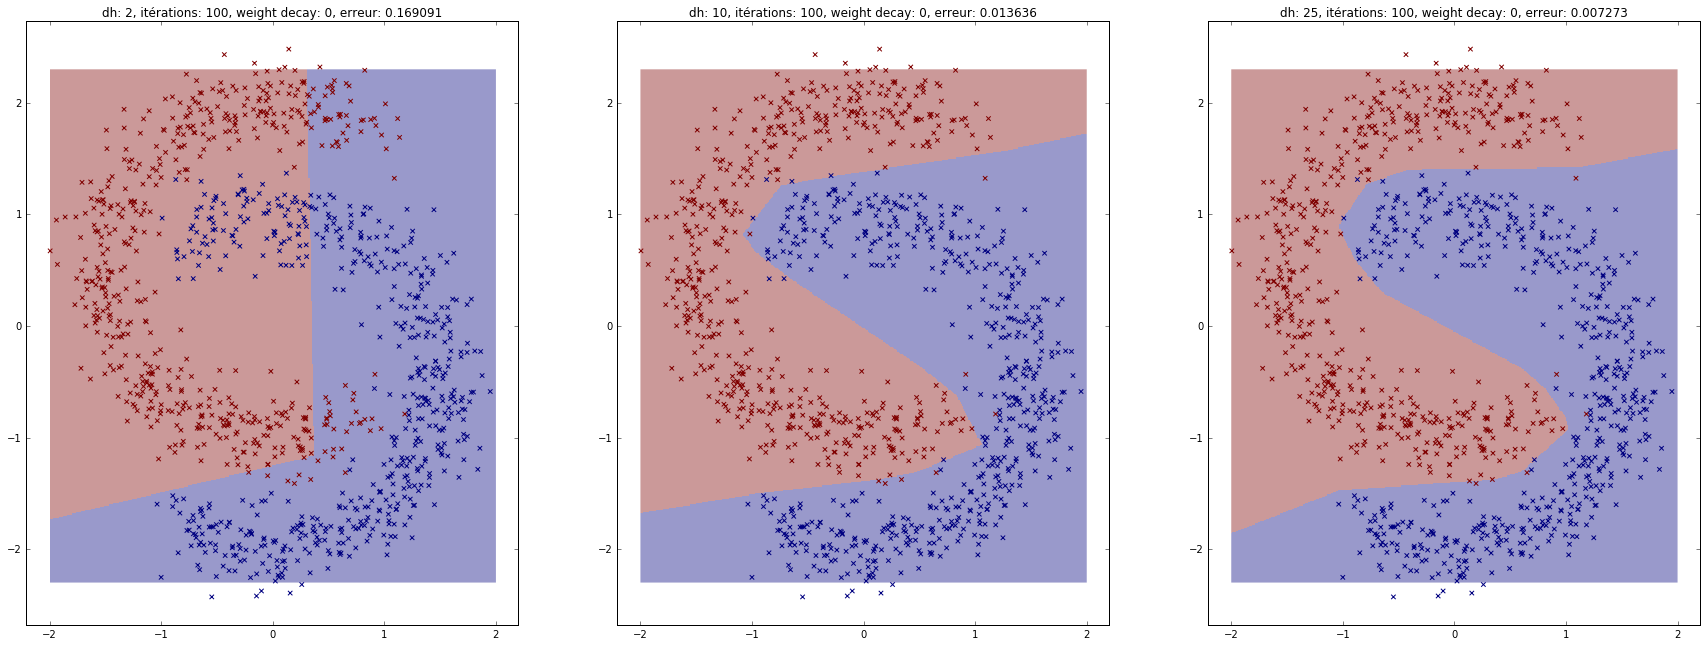

In [8]:
d = 2
m = 2

plt.figure(figsize=(30, 40))
i = 1

for dh in [2, 10, 25]:

    debut = time.time()
    mlp = MLP(d, dh, m)
    
    mlp.train(data_x, data_y, 100, 10, 0.02, 0)
    fin = time.time()
    print 'dh: %d, temps: %f sec, 100 itérations, weight decay: 0, erreur: %f' % (dh, fin - debut, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y))
    
    axe = plt.subplot(1, 3, i)
    plt.title('dh: %d, itérations: 100, weight decay: 0, erreur: %f' % (dh, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y)))
    plot_regions(mlp, axe)
    
    i += 1
    
plt.show()

On remarque donc que l'augmentation du nombre de neurones cachés augmente la capacité.

On remarque aussi qu'en augmentant le nombre de neurones au delà de 10, l'erreur diminue faiblement.

Ainsi, On choisit de prendre 10 neurones sur la couche cachée.

#### Choix de l'hyper-paramètre : Nombre d'itérations

dh: 10, temps: 0.413893 sec, 10 itérations, weight decay: 0, erreur: 0.200000
dh: 10, temps: 4.136631 sec, 100 itérations, weight decay: 0, erreur: 0.013636
dh: 10, temps: 18.344034 sec, 500 itérations, weight decay: 0, erreur: 0.008182
dh: 10, temps: 29.950955 sec, 800 itérations, weight decay: 0, erreur: 0.007273
dh: 10, temps: 55.644246 sec, 1500 itérations, weight decay: 0, erreur: 0.007273


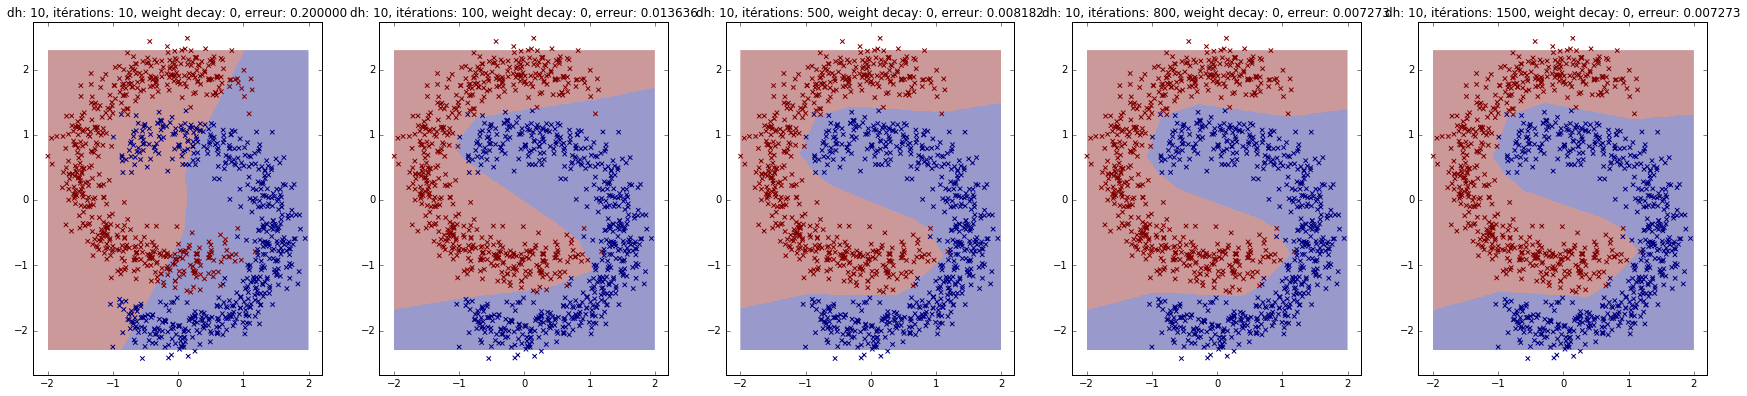

In [9]:
d = 2
m = 2

plt.figure(figsize=(30, 40))
i = 1

for it in [10, 100, 500, 800, 1500]:

    debut = time.time()
    mlp = MLP(d, 10, m)
    
    mlp.train(data_x, data_y, it, 10, 0.02, 0)
    fin = time.time()
    print 'dh: 10, temps: %f sec, %d itérations, weight decay: 0, erreur: %f' % (fin - debut, it, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y))
    
    axe = plt.subplot(1, 5, i)
    plt.title('dh: 10, itérations: %d, weight decay: 0, erreur: %f' % (it, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y)))
    plot_regions(mlp, axe)
    
    i += 1
    
plt.show()

On remarque donc que l'augmentation du nombre d'itérations augmente la capacité.

On remarque qu'au delà de 800 itérations, l'erreur ne diminue plus.

#### Choix de l'hyper-paramètre : Weight decay

dh: 10, temps: 19.119264 sec, 500 itérations, weight decay: 0.000000, erreur: 0.008182
dh: 10, temps: 18.390820 sec, 500 itérations, weight decay: 0.005000, erreur: 0.100000
dh: 10, temps: 19.289938 sec, 500 itérations, weight decay: 0.010000, erreur: 0.215455


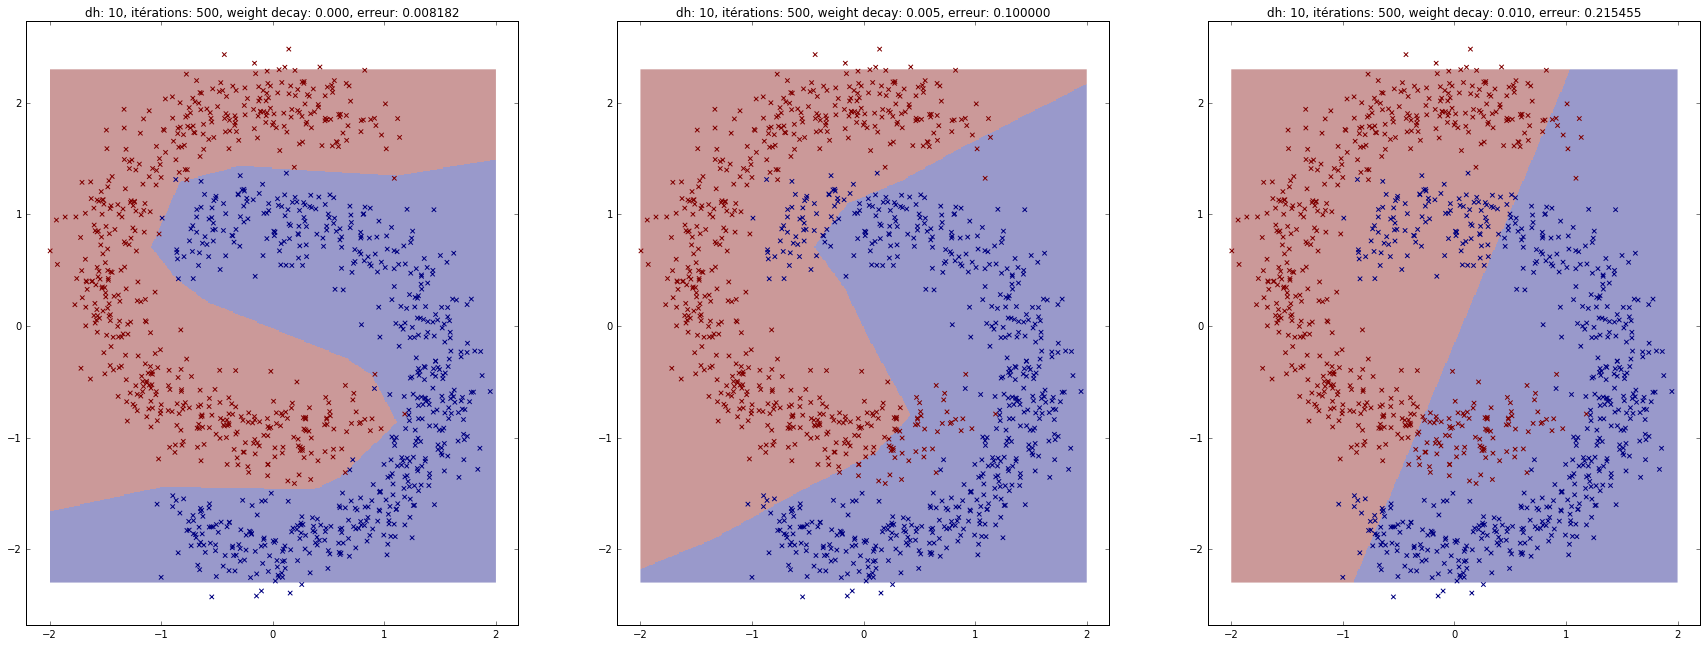

In [10]:
d = 2
dh = 10
m = 2

plt.figure(figsize=(30, 40))
i = 1

for wd in [0, 0.005, 0.01]:

    debut = time.time()
    mlp = MLP(d, dh, m)
    
    mlp.train(data_x, data_y, 500, 10, 0.02, wd)
    fin = time.time()
    print 'dh: 10, temps: %f sec, 500 itérations, weight decay: %f, erreur: %f' % (fin - debut, wd, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y))
    
    axe = plt.subplot(1, 3, i)
    plt.title('dh: 10, itérations: 500, weight decay: %.3f, erreur: %f' % (wd, float(np.abs(mlp.predict(data_x).T - data_y).sum())/len(data_y)))
    plot_regions(mlp, axe)
    
    i += 1
    
plt.show()

On remarque donc que l'augmentation du weight decay diminue la capacité.

Dans ce cas ci on ne fait pas de validation sur un ensemble séparé, mais dans le cas général le weight decay permet de vérifier qu'on ne fait pas de surapprentissage.

Avec les hyper-paramètres sélectionnés (dh=10, 800 itérations et weight_decay=0), on obtient une erreur de 0.72%.

### 6. Version matricielle

Dans la suite, on adapte l'implémentation précédente pour utiliser les optimisations de numpy sur les calculs matriciels.

Nous allons cette fois ci utiliser la première dimension des vecteurs, matrices et tenseurs pour énumérer les exemples, ce qui implique que toutes les expressions doivent être transposées.

Nous nous sommes également aperçu que l'allocation d'espace mémoire était moins efficace en manipulant des matrices plus grandes, donc nous avons essayé de réduire au minimum le besoin en nouvelle allocation, et avons utilisé des buffers créés une seule fois au début. La nouvelle implémentation est effectuée dans la suite, dans la classe MLP_MAT. La plupart de méthodes sont réécrites pour adapter les calculs dans le bon sens.

In [11]:
def softmax2(x):
    x_max = np.max(x, axis=1).reshape(-1, 1)
    r = np.exp(x - x_max)
    return r / np.sum(r, axis=1).reshape(-1, 1)

In [12]:
class MLP_MAT(MLP):
            
    def init_w(self, d1, d2):
        return np.random.uniform(-1/d1**0.5, 1/d1**0.5, (d1, d2))
    
    def init_b(self, d):
        return np.zeros(d)
    
    def init_buffer_fprop(self, batch_size):
        return [
            np.zeros((batch_size, self.dh)), # ha
            np.zeros((batch_size, self.dh)), # hs
            np.zeros((batch_size, self.m)), # oa
            np.zeros((batch_size, self.m)) # os
        ]
    
    def init_buffer_bprop(self, batch_size):
        return [
            np.zeros((batch_size, self.m)), # grad_b2
            np.zeros((batch_size, self.dh, self.m)), # grad_w2
            np.zeros((batch_size, self.dh)), # grad_b1
            np.zeros((batch_size, self.d, self.dh)) # grad_w1
        ]
    
    def init_buffer_grad(self):
        return [
            np.zeros(self.b2.shape),
            np.zeros(self.w2.shape),
            np.zeros(self.b1.shape),
            np.zeros(self.w1.shape),
        ]
    
    def train(self, x, y, n_iter=100, batch_size=100, learning_rate=0.1, weight_decay=0.001, callback=None):
        """
        Lance l'apprentissage
        
        x: données d'apprentissage, un exemple par ligne
        y: valeurs des classes pour les données d'apprentissage, chaque ligne représente un exemple
        n_iter: nombre maximum d'époques
        batch_size: taille des batchs
        learning_rate: paramètre pour la descente de gradient
        weight_decay: régularisation L2
        callback: fonction appelée à chaque époque, si elle renvoi False alors on stoppe l'apprentissage
        """
        
        buffers_fprop = self.init_buffer_fprop(batch_size)
        buffers_bprop = self.init_buffer_bprop(batch_size)
        buffers_grad = self.init_buffer_grad()
        
        for current_iter in range(n_iter):
            loss = 0
            for i in range(int(x.shape[0] / batch_size)):
                # prendre en compte le dernier batch qui peut être de longueur < batch_size
                n = min(batch_size, x.shape[0]-i*batch_size)

                batch_loss = self.gradient_batch(x[i*batch_size:i*batch_size+n], y[i*batch_size:i*batch_size+n],
                                                 buffers_fprop, buffers_bprop, buffers_grad)

                # mise à jour des paramètres
                buffers_grad[0] *= learning_rate
                buffers_grad[1] *= learning_rate
                buffers_grad[2] *= learning_rate
                buffers_grad[3] *= learning_rate
                
                self.b2 *= (1 - weight_decay/n)
                self.b2 -= buffers_grad[0]
                self.w2 *= (1 - weight_decay/n)
                self.w2 -= buffers_grad[1]
                self.b1 *= (1 - weight_decay/n)
                self.b1 -= buffers_grad[2]
                self.w1 *= (1 - weight_decay/n)
                self.w1 -= buffers_grad[3]
                
                loss += batch_loss
                
            # appel d'un callback à chaque époque qui détermine si on
            # doit arrêter l'entrainement
            if callback != None:
                if callback(self, loss/int(x.shape[0] / batch_size)) == False:
                    break
    
    def fprop(self, x, buffers):
        """
        Forward propagation
        
        x: données d'entrainement, un exemple par ligne
        """
        ha = buffers[0]
        hs = buffers[1]
        oa = buffers[2]
        os = buffers[3]
        
        np.dot(x, self.w1, out=ha)
        ha += self.b1
        
        np.copyto(hs, ha)
        hs[hs<=0] = 0

        np.dot(hs, self.w2, out=oa)
        oa += self.b2
        
        os = softmax2(oa)
        
        return (ha, hs, oa, os)
        
    def bprop(self, x, y, ha, hs, oa, os, buffers):
        """
        Back propagation
        
        x: matrice des valeurs de x, chaque ligne représente un exemple
        y: vecteur ligne des valeurs des classes à prédire
        ha, hs, oa, os: valeurs retournées par la fonction fprop
        """
        grad_b2 = buffers[0]
        grad_w2 = buffers[1]
        grad_b1 = buffers[2]
        grad_w1 = buffers[3]
        
        np.copyto(grad_b2, os)
        grad_b2[np.arange(os.shape[0]), y] -= 1
        
        np.matmul(hs[:,:,None], grad_b2[:,None,:], out=grad_w2)
        np.dot(grad_b2, self.w2.T, out=grad_b1)
        grad_b1[ha <= 0] = 0
        
        np.matmul(x[:,:,None], grad_b1[:,None,:], out=grad_w1)

        return (grad_b2, grad_w2, grad_b1, grad_w1)
    
    def gradient_batch(self, x, y, buffers_fprop, buffers_bprop, out):
        """
        Calcule les gradients sur un batch
        
        x: matrice des valeurs de x, chaque ligne représente un exemple
        y: vecteur colonne des valeurs des classes à prédire, chaque ligne représente un exemple
        """
        
        (ha, hs, oa, os) = self.fprop(x, buffers_fprop)
        (grad_b2, grad_w2, grad_b1, grad_w1) = self.bprop(x, y, ha, hs, oa, os, buffers_bprop)
        
        loss = -np.sum(np.log(os[np.arange(os.shape[0]), y])) / y.shape[0]
       
        np.mean(grad_b2, axis=0, out=out[0])
        np.mean(grad_w2, axis=0, out=out[1])
        np.mean(grad_b1, axis=0, out=out[2])
        np.mean(grad_w1, axis=0, out=out[3])
        
        return loss
    
    def predict(self, x):
        buffers = self.init_buffer_fprop(x.shape[0])

        ha, hs, oa, os = self.fprop(x, buffers)
        return np.argmax(os, axis=1)

### 7. Comparaison des gradients

Vérifions maintenant que les gradients sont corrects, pour des données du dataset 2 moons.

In [13]:
d = 2
dh = 3
m = 4
n = 10

mlp = MLP(d, dh, m)
mlp_mat = MLP_MAT(d, dh, m)

mlp_mat.b1 = mlp.b1.reshape(-1)
mlp_mat.w1 = mlp.w1.T
mlp_mat.b2 = mlp.b2.reshape(-1)
mlp_mat.w2 = mlp.w2.T

buffers_fprop = mlp_mat.init_buffer_fprop(n)
buffers_bprop = mlp_mat.init_buffer_bprop(n)
buffers_grad = mlp_mat.init_buffer_grad()

(grad_b2, grad_w2, grad_b1, grad_w1, loss) = mlp.gradient_batch(data_x[:n], data_y[:n])
loss = mlp_mat.gradient_batch(data_x[:n], data_y[:n], buffers_fprop, buffers_bprop, buffers_grad)

# Vérification du gradient w1
print '- affichage de w1'
print grad_w1
print buffers_grad[3].T

# Vérification du gradient b1
print '- affichage de b1'
print grad_b1
print buffers_grad[2]

# Vérification du gradient w2
print '- affichage de w2'
print grad_w2
print buffers_grad[1].T

# Vérification du gradient w1
print '- affichage de b2'
print grad_b2
print buffers_grad[0]


- affichage de w1
[[ 0.00709393  0.15890136]
 [ 0.02439562  0.06151496]
 [-0.01584172  0.04322289]]
[[ 0.00709393  0.15890136]
 [ 0.02439562  0.06151496]
 [-0.01584172  0.04322289]]
- affichage de b1
[[-0.0758725 ]
 [-0.04259516]
 [-0.04456396]]
[-0.0758725  -0.04259516 -0.04456396]
- affichage de w2
[[-0.10055725  0.0143417  -0.03713262]
 [ 0.00697068 -0.05612582 -0.00189236]
 [ 0.04371758  0.02020061  0.01824957]
 [ 0.04986898  0.02158351  0.02077541]]
[[-0.10055725  0.0143417  -0.03713262]
 [ 0.00697068 -0.05612582 -0.00189236]
 [ 0.04371758  0.02020061  0.01824957]
 [ 0.04986898  0.02158351  0.02077541]]
- affichage de b2
[[-0.11713815]
 [-0.35776683]
 [ 0.23039854]
 [ 0.24450644]]
[-0.11713815 -0.35776683  0.23039854  0.24450644]


Les gradients obtenus sont bien identiques, on peut donc valider l'implémentation matricielle.

### 8. Comparaison des performances boucle vs matrice

Dans la suite on mesure le temps pris par une époque sur MNIST pour les deux implémentations.

#### Chargement des données MNIST

In [14]:
import gzip, pickle

with gzip.open('mnist.pkl.gz') as f:
    data = pickle.load(f)
    
mnist_x = np.array(data[0][0])
mnist_y = np.array(data[0][1])

train_x = mnist_x[:30000,]
train_y = mnist_y[:30000]
valid_x = mnist_x[30000:40000,]
valid_y = mnist_y[30000:40000]
test_x = mnist_x[40000:50000,]
test_y = mnist_y[40000:50000]

In [15]:
batch_size = 100
d = 784
dh = 200
m = 10
buffer_w2 = np.zeros((batch_size, dh, d))
buffer_w1 = np.zeros((batch_size, m, dh))

In [16]:
mlp_mat = MLP_MAT(d=784, dh=200, m=10)
mlp = MLP(d=784, dh=200, m=10)
    
debut = time.time()
mlp.train(mnist_x, mnist_y, n_iter=1, batch_size=100)
fin = time.time()
print 'temps pour 1 époque version boucle: %f secondes' % (fin-debut)

debut = time.time()
mlp_mat.train(mnist_x, mnist_y, n_iter=1, batch_size=100)
fin = time.time()
print 'temps pour 1 époque version matrice: %f secondes' % (fin-debut)

temps pour 1 époque version boucle: 52.840162 secondes
temps pour 1 époque version matrice: 31.009757 secondes


Le temps obtenu pour la version matricielle est donc 1.5 fois meilleur, par la suite, on va uniquement utiliser cette version.

### 9. Calcul de l'erreur de classification totale et du coût optimisé total

On définit une fonction callback courbes_erreur qui est appelé par notre méthode train à chaque époque, ce qui permet de choisir si on veut conserver les erreurs de classification sur les ensembles d'entrainement, de validation et de test, ainsi que le coût optimisé total.

In [22]:
errors_train = []
errors_valid = []
errors_test = []
losses = []
best_error = float("inf")

patience = 10

In [32]:
import io
output = io.open('output.txt', 'a', encoding='utf8')

In [23]:
def courbes_erreur(mlp, loss):
    global best_error, patience
    
    losses.append(loss)
    errors_train.append(float(np.abs(mlp.predict(train_x).T != train_y).sum())/len(train_y))
    errors_valid.append(float(np.abs(mlp.predict(valid_x).T != valid_y).sum())/len(valid_y))
    output.write('époque %d: erreur train %f\n' % (len(errors_train), errors_train[-1]))
    
    if errors_valid[-1] < best_error:
        patience = 10
        best_error = errors_valid[-1]
        errors_test.append(float(np.abs(mlp.predict(test_x).T != test_y).sum())/len(test_y))
        
        np.savez('best_model.npz', mlp.b2, mlp.w2, mlp.b1,  mlp.w1)
        
        output.write('\tmeilleure erreur de validation !\n')
        output.write('\terreur valid: %f, erreur test: %f\n' % (errors_valid[-1], errors_test[-1]))
        output.flush()
    else:
        # l'erreur de test n'est pas améliorée, on garde l'ancienne
        errors_test.append(errors_test[-1])
        
        # si on n'améliore plus, on arrête
        patience -= 1
        if patience == 0:
            return False

### 10. Entrainement sur MNIST

Dans la suite on effectue l'entrainement d'un réseau sur les données MNIST.

In [24]:
dh = 300

mlp = MLP_MAT(784, dh, 10)

In [25]:
patience = 10
debut = time.time()
mlp.train(train_x, train_y, 1000, 20, 0.01, 0.0001, courbes_erreur)
print 'Temps écoulé, %f sec' % (time.time() - debut)

Temps écoulé, 3069.167158 sec


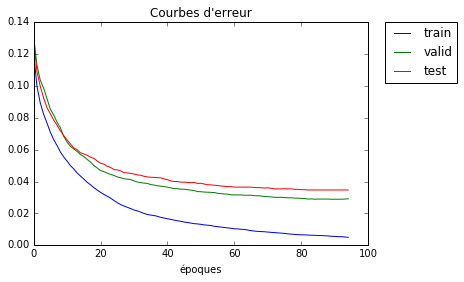

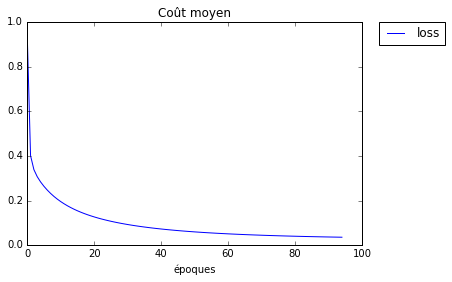

In [26]:
plt.figure()
plt.plot(errors_train, label='train')
plt.plot(errors_valid, label='valid')
plt.plot(errors_test, label='test')
plt.title("Courbes d'erreur")
plt.xlabel('époques')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.figure()
plt.plot(losses, label='loss')
plt.title('Coût moyen')
plt.xlabel('époques')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

On voit que les courbes commencent à diverger, donc en dernier lieu comme moyen de régularisation on utilise une méthode qui consiste à rajouter du bruit aux données d'apprentissage, et on laisse l'apprentissage se poursuivre encore quelques époques...

In [33]:
train_x_noise = train_x.copy()

def ajout_bruit(mlp, loss):
    global train_x_noise
    
    # dropout
    noisy = train_x * np.random.binomial(1, 0.75, train_x.shape)
    # gaussian noise
    # noisy = train_x + np.random.normal(0, 0.35, train_x.shape)
    np.copyto(train_x_noise, noisy)
    
    # rappel de la fonction qui stocke les valeurs
    # d'erreur et coût
    return courbes_erreur(mlp, loss)
    
    
patience = 10
debut = time.time()
mlp.train(train_x_noise, train_y, 1000, 20, 0.01, 0, ajout_bruit)
print 'Temps écoulé, %f sec' % (time.time() - debut)

Temps écoulé, 589.613758 sec


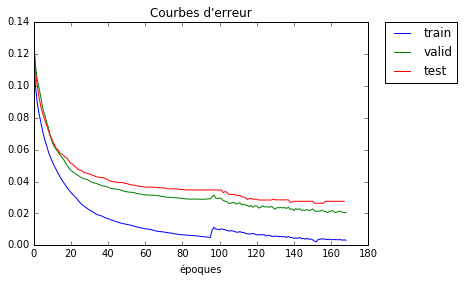

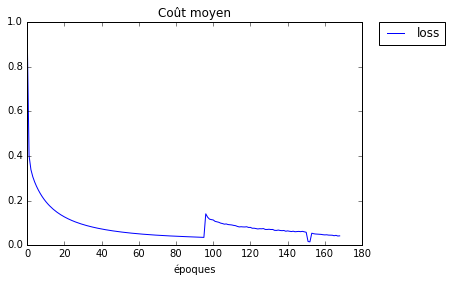

In [35]:
plt.figure()
plt.plot(errors_train, label='train')
plt.plot(errors_valid, label='valid')
plt.plot(errors_test, label='test')
plt.title("Courbes d'erreur")
plt.xlabel('époques')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.figure()
plt.plot(losses, label='loss')
plt.title('Coût moyen')
plt.xlabel('époques')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [29]:
output.close()

In [30]:
pickled = np.load('best_model.npz')
best_model = pickled.items()

dh=300
mlp_test = MLP_MAT(784, dh, 10)

mlp_test.b2 = best_model[1][1]
mlp_test.w2 = best_model[0][1]
mlp_test.b1 = best_model[3][1]
mlp_test.w1 = best_model[2][1]

print 'Erreur de test pour le meilleur modèle entrainé:' ,
print float(np.abs(mlp_test.predict(test_x).T != test_y).sum())/len(test_y)
pickled.close()

Erreur de test pour le meilleur modèle entrainé: 0.0276


Bonne correction et bonnes fêtes !

Marc et Thomas